# xgboost fraud detection

### This notebook is based on [this blogpost](https://www.toptal.com/machine-learning/generative-adversarial-networks) and its [github repo](https://github.com/codyznash/GANs_for_Credit_Card_Data).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb

In [3]:
# Load engineered dataset from EDA section
data = pickle.load(open('./credicard.engineered.pkl','rb'))

In [4]:
# define the columns we want to test on, in case we want to use less than the full set
test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]
print(len(test_cols))
print(test_cols)

31
Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')


In [5]:
# data columns will be all other columns except class
label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('\n# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
('\n# of data columns: ', 30)


In [6]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [7]:
# Set up the test and train sets
np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)

print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

('classes 0, 1: ', 284315, 492)
('train, test: ', 199364, 85443)


In [8]:
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
from utils_GAN import *

Using TensorFlow backend.


In [10]:
# Run the xgboost algorithm, maximize recall on the test set
results_dict = {}

xgb_params = {
#    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

('best iteration: ', 31)
('recall', 0.7635135135135135)
('precision', 0.9416666666666667)
('roc_auc', 0.9764897818857605)
Confusion Matrix


,Pred 0,Pred 1
True 0,85288,7
True 1,35,113


Accuracy : 0


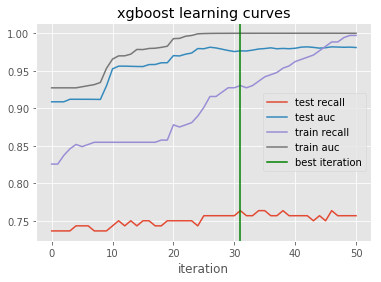

In [11]:
# Let's look at how the metrics changed on the train and test sets as more trees were added
for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
        
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()

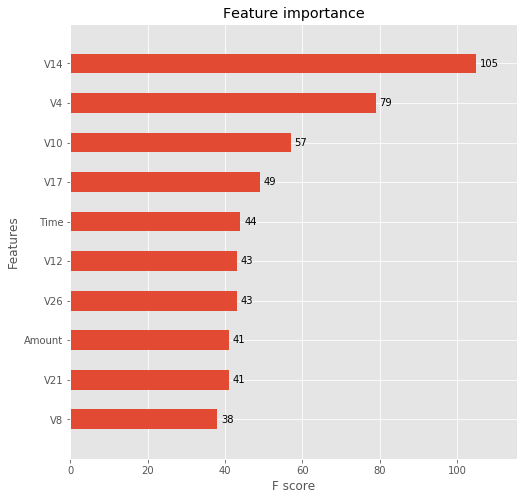

In [12]:
# Plot feature importances
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [13]:
# Generate list of features sorted by importance in detecting fraud
# https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )

['V14', 'V4', 'V10', 'V17', 'Time', 'V26', 'V12', 'V21', 'Amount', 'V8', 'V11', 'V28', 'V7', 'V19', 'V22', 'V3', 'V20', 'V6', 'V27', 'V13', 'V16', 'V25', 'V24', 'V2', 'V18', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']


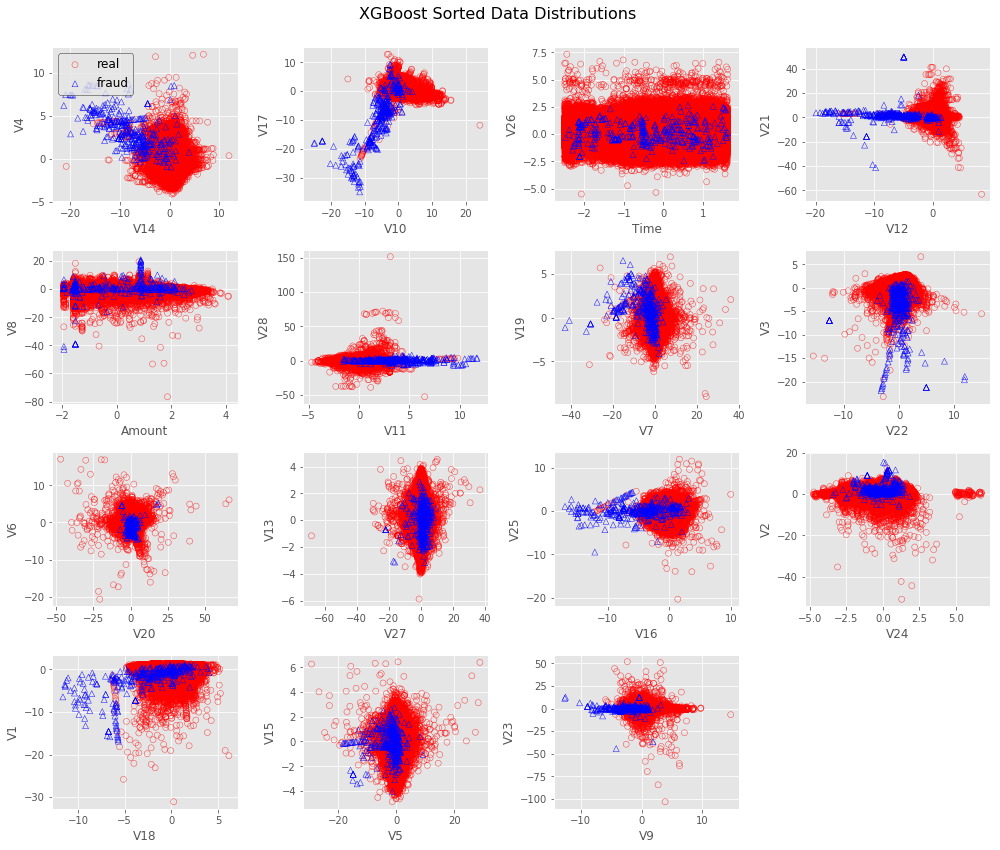

In [14]:
# Plot all of the training data with paired features sorted by importance
# This takes a while
colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4.
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()

In [15]:
# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.2682695795279726
0.7196856730011519
1.9306977288832496
5.17947467923121
13.894954943731374
37.27593720314938
100.0


,ratio,best,test-auc-mean,test-auc-std,test-recall-mean,test-recall-std,train-auc-mean,train-auc-std,train-recall-mean,train-recall-std
0,0.100000,0,0.928481,0.100965,0.963617,0.011517,0.994223,0.005743,0.986262,0.003127
1,0.268270,1,0.961183,0.031354,0.938778,0.036045,0.998605,0.000322,0.990842,0.002090
2,0.719686,1,0.968956,0.004989,0.904672,0.011522,0.996926,0.000349,0.974548,0.008628
3,1.930698,1,0.967932,0.016464,0.871982,0.022466,0.987082,0.002505,0.929382,0.004574
4,5.179475,0,0.949072,0.004681,0.851627,0.026320,0.962013,0.002299,0.892954,0.010674
5,13.894955,0,0.940690,0.017112,0.840316,0.038538,0.954568,0.003276,0.872450,0.006503
6,37.275937,0,0.922135,0.029144,0.824408,0.056779,0.930331,0.006132,0.841476,0.015474
7,100.000000,0,0.916909,0.025283,0.803685,0.046228,0.922589,0.006383,0.825135,0.009177


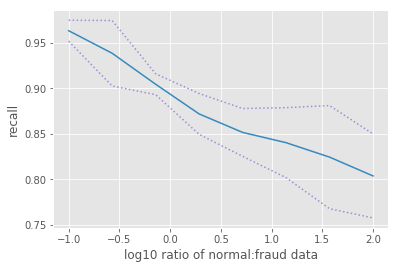

In [16]:
# Recall decreases as more normal data is added

# metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()